# Analysis of the 5min pv data Part 1 

This notebook presents a high level analysis of the 5min pv data.

The following questions will be answered:

I) 5min data analysis
1.	How many pv systems are there in the UK?
2.	Where in the UK are the pv systems located?
3.	How many pv systems are there in each region of the UK?
4.	What is the estimated energy shortfall in 2019? (what is the difference between the total energy demand and the energy produced by the pv systems)

II) Analysis of missing PV
1.	How many pv systems are included in the metadata but not in the 5min data?
2.	Analysis of missing data in the metadata
3.	What is the average power produced by pv systems per year
4.	Where are the pv systems and how much energy was generated by year?

III) Pv 5min vs. pv metadata
1.	How many pv systems are there in each data source per year?


# Preprocessing Data
### Loading and Cleaning data

In [ ]:
!pip install vaex
!pip install --upgrade vaex
!pip install dash
!pip install rtree 
!pip install pygeos
!pip install geopandas
!pip install folium matplotlib mapclassify geopandas -q -q -q
!pip install folium matplotlib mapclassify -q -q -q

In [2]:
# Have to restart runtime for this to work
import vaex as vx
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
import pygeos
import rtree
import folium
from branca.utilities import split_six
from datetime import datetime
import plotly.express as px


### The Data

The Following datasets were used

- **5min parquet**: Time series data of PV solar generation data. Avalible: https://huggingface.co/datasets/openclimatefix/uk_pv/tree/main. For information about the data read more here https://huggingface.co/datasets/openclimatefix/uk_pv
- **metadata**: Metadata of the different PV systems. Avalible: https://huggingface.co/datasets/openclimatefix/uk_pv/tree/main. Read more here https://huggingface.co/datasets/openclimatefix/uk_pv
- **energy consumption**: 
Sub-national total electricity consumption in (GWh) by region in 2019. Original datasource avalible: https://www.gov.uk/government/statistical-data-sets/regional-and-local-authority-electricity-consumption-statistics. )

  - Additional Notes:
  
     - Regions Include: North East, North West, Yorkshire and The Humber, East Midlands, West Midlands, East, London, Inner London, Outer London, South East, South West, Wales, Scotland

     - Electricity consumption as reported by all local authorities (Scotland includes unallocated authorities, unclear if  other regions do the same) and measured by ‘all_meters'.
- **UK districts**: Avalible 'http://geoportal1-ons.opendata.arcgis.com/datasets/01fd6b2d7600446d8af768005992f76a_4.geojson'. Geojason representation of UK districts 



In [3]:
# Load Datasets
min5= vx.open('/content/5min.parquet')   # 5 min data
metadata= pd.read_csv('metadata.csv') # Metadata
energy_consumption= pd.read_csv('/content/energy_consumption.csv') # energy_consumption

# Load data defining boundaries of UK Districts
url= 'http://geoportal1-ons.opendata.arcgis.com/datasets/01fd6b2d7600446d8af768005992f76a_4.geojson'
districts = gpd.read_file(url) 

In [4]:
# clean energy consumption dataset
energy_consumption['region']= energy_consumption['region'].str.replace(' ','')   

# Cleaning disticts df
districts = districts[['nuts118nm','long','lat','geometry']] #select only relivant columns
districts['nuts118nm']= districts['nuts118nm'].str.replace('England','').str.replace('(','').str.replace(')','').str.replace('of','').str.replace(' ','') # clean renaming colum with region names
districts = districts.rename(columns={"nuts118nm": "region",   
                                      "long":"district_long",
                                      "lat":"district_lat"}) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [5]:
# Decomposing date
min5['day'],min5['month'],min5['year'] = min5.timestamp.dt.day, min5.timestamp.dt.month,min5.timestamp.dt.year,
min5['hour'],min5['minute'],min5['second'] = min5.timestamp.dt.hour,  min5.timestamp.dt.minute, min5.timestamp.dt.second

How many pv systems are there in each dataset? 

There are 1311 unique pv systems are included in the 5min dataset and 24662 unique pv systems included in the metadata file.

In [6]:
# Generating a list of Unique SS_ids
ss_id = min5.ss_id.unique()

print('Number of unique ss_id in 5min data:',len(ss_id))
print('Number of unique ss_id in metadata:',len(metadata.ss_id.unique()))

Number of unique ss_id in 5min data: 1311
Number of unique ss_id in metadata: 24662



In order to perform further analysis, two new dataframes will be created:
   1. **min5_meta**: Will contain unique pv systems from the 5min dataframe along with their associated metadata.
   2. **missing_pv**: Will contain all the pv systems which are not included in the 5min dataframe.

In [7]:
# ---- Step 1: Creating min5_meta
ssid_df = pd.DataFrame(ss_id,columns=['ss_id'])
min5_meta  = ssid_df.merge(metadata, on='ss_id', how='left') # Merging 1 and 2
min5_meta.head(2)

ss_id  latitude_rounded  longitude_rounded    llsoacd  orientation  tilt  \
0   3238             52.12              -2.39  E01014030        180.0  30.0   
1   3431             51.85              -2.26  E01022334        180.0  20.0   

    kwp operational_at  
0  3.96     2011-11-25  
1  3.99     2011-12-15

Checking for missing data and verifying data types in min5_meta

In [8]:
min5_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1311 entries, 0 to 1310
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ss_id              1311 non-null   int64  
 1   latitude_rounded   1310 non-null   float64
 2   longitude_rounded  1310 non-null   float64
 3   llsoacd            1310 non-null   object 
 4   orientation        1310 non-null   float64
 5   tilt               1310 non-null   float64
 6   kwp                1310 non-null   float64
 7   operational_at     1310 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 92.2+ KB


There is one ss_id with missing data. This means that there was one ss_id in the 5min dataset, which had no corresponding metadata. The pv system is identified below.

In [9]:
test= np.isnan(min5_meta['latitude_rounded']).reset_index()

# Finding the index number of the missing value
for loc in np.where(test['latitude_rounded']==True):
  print(min5_meta.iloc[loc])

     ss_id  latitude_rounded  longitude_rounded llsoacd  orientation  tilt  \
264  27068               NaN                NaN     NaN          NaN   NaN   

     kwp operational_at  
264  NaN            NaN  


This system will be droped from the subsequent analysis

In [10]:
# Drop the ss_id with the missing data
min5_meta = min5_meta.dropna()

-----------

# I) 5min Data Analysis (min5_meta Analysis)

### Where are the pv systems?

A map of the pv systems included in the 5min data, by region

In [11]:
#Counting the number of pv systems in each region    
#This is an approximation due to rounding the lat and long corrdinates of each pv system
# Creating geo pandas file for SS_ID location
min5_meta_geo = gpd.GeoDataFrame(min5_meta,geometry=gpd.points_from_xy(min5_meta.longitude_rounded, 
                                                                  min5_meta.latitude_rounded))
min5_meta_geo.head(2)

ss_id  latitude_rounded  longitude_rounded    llsoacd  orientation  tilt  \
0   3238             52.12              -2.39  E01014030        180.0  30.0   
1   3431             51.85              -2.26  E01022334        180.0  20.0   

    kwp operational_at                   geometry  
0  3.96     2011-11-25  POINT (-2.39000 52.12000)  
1  3.99     2011-12-15  POINT (-2.26000 51.85000)

In [12]:
# Mapping
m = folium.Map(location=[55, 4], zoom_start=5) # map of the UK

districts.explore(m=m,
                  column="region",  
                  scheme="naturalbreaks",  
                  legend=True, 
                  cmap='YlGn',
                  legend_kwds=dict(), 
                  name="region")

for lat,lon,tip  in zip(min5_meta_geo.latitude_rounded, 
                        min5_meta_geo.longitude_rounded, 
                        min5_meta_geo.ss_id):
  folium.Marker(location=[lat,lon], tooltip = tip).add_to(m)
    
folium.LayerControl().add_to(m) 
m  

- How many pv systems are there in each region? (estimated)

In [13]:
# Counting the number of pv systems within each reagion 
districts['count_pv_systems']=districts.apply(lambda x: min5_meta_geo['geometry'].within(x['geometry']).sum(), axis=1)

In [14]:
# Now merging min5_meta_geo and disctricts 
pv_geo = gpd.sjoin(min5_meta_geo, districts, op='within')
pv_geo.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  


ss_id  latitude_rounded  longitude_rounded    llsoacd  orientation  tilt  \
0   3238             52.12              -2.39  E01014030        180.0  30.0   
9   6620             52.69              -2.43  E01014183        180.0  35.0   

    kwp operational_at                   geometry  index_right        region  \
0  3.96     2011-11-25  POINT (-2.39000 52.12000)            4  WestMidlands   
9  2.50     2012-09-29  POINT (-2.43000 52.69000)            4  WestMidlands   

   district_long  district_lat  count_pv_systems  
0       -2.20358     52.556969                41  
9       -2.20358     52.556969                41

A choropleth map, showing the number of pv systems in each region. The darker the region, the more pv systems located there

In [15]:
m = folium.Map(location=[55, 4], zoom_start=5) # map of the UK

districts.explore(m=m,
                  column="count_pv_systems",  
                  scheme="naturalbreaks",  
                  legend=True, 
                  cmap='YlGn',
                  legend_kwds=dict(), 
                  name="Districts")

folium.LayerControl().add_to(m)  
m  

3)  What is the estimated energy shortfall in 2019?

This will be the difference between energy generated by the pv systems and the energy demanded by region.

Notes: 
  - The **lat,long are rounded** so they are not precise measurments. 
  - Total consumption in (GWh) for 2019 from all local authorities (scottland includes unallocated). **Not clear if the other regions also include data from unallocated authorites**.    
  -Total consumption in (GWh) figures is based on 'all meters' which is the sum of 'all domestic' and 'all non-domestic' meters

In [16]:
# Creating dataframe with SS_id and region
ss_id_region = pd.DataFrame(pv_geo[['ss_id','region']]) # geopandas to pandas
ss_id_region_vx = vx.from_pandas(df=ss_id_region, copy_index=False) # pandas to vaex to merge with min5 data

# Creating dataframe with SS_id and power generation
min5 = min5.drop(['timestamp'])
min5_2019= min5[min5['year']==2019] # filter for only 2019
min5_2019 = min5_2019[['generation_wh','ss_id']] # select relevant columns 

# Merging the two dataframes
min5_regions = min5_2019.join(ss_id_region_vx, on ='ss_id',) # merging 
min5_regions.head(2)

#    generation_wh    ss_id  region
  0          199.867     2607  East
  1          160.989     2625  SouthWest

In [17]:
# grouping data by ss_id and year and finding the average power generated for each pv system
avg_yearly = min5_regions.groupby(['region']).agg({'generation_wh': 'mean'}).dropna()
avg_yearly = avg_yearly.to_pandas_df() # back to pandas 
avg_yearly.head(10)

region  generation_wh
0                   East      25.944731
1           WestMidlands      24.741245
2               Scotland      22.773709
3              SouthWest      26.318245
4           EastMidlands      27.613667
5              NorthWest      18.048503
6                  Wales      20.698346
7  YorkshireandTheHumber      23.103546
8              SouthEast      25.776048
9                 London      21.990807

---

In [18]:
# merge ss_id region with districts to get geographical info of each ss_id
ss_id_location = ss_id_region.merge(districts, on='region', how='left')

# merge geographical info of each ss_id with energy consumed per region
regional_energy_profile = ss_id_location.merge(energy_consumption, on='region', how='left')

select_energy_profile = regional_energy_profile[['region','geometry','all_meters']]
select_energy_profile.set_index('region')

geometry  all_meters
region                                                                     
WestMidlands  POLYGON ((-1.86073 53.18843, -1.89863 53.19996...     23415.7
WestMidlands  POLYGON ((-1.86073 53.18843, -1.89863 53.19996...     23415.7
WestMidlands  POLYGON ((-1.86073 53.18843, -1.89863 53.19996...     23415.7
WestMidlands  POLYGON ((-1.86073 53.18843, -1.89863 53.19996...     23415.7
WestMidlands  POLYGON ((-1.86073 53.18843, -1.89863 53.19996...     23415.7
...                                                         ...         ...
London        POLYGON ((-0.01192 51.68088, -0.10578 51.69188...     37293.0
London        POLYGON ((-0.01192 51.68088, -0.10578 51.69188...     37293.0
London        POLYGON ((-0.01192 51.68088, -0.10578 51.69188...     37293.0
London        POLYGON ((-0.01192 51.68088, -0.10578 51.69188...     37293.0
London        POLYGON ((-0.01192 51.68088, -0.10578 51.69188...     37293.0

[1295 rows x 2 columns]

In [19]:
# merge regional energy profile with avg_yearly to get the power generated and consumed per region
energy_produced_consumed = avg_yearly.merge(select_energy_profile, how='left') 
energy_produced_consumed.head(2)

region  generation_wh                                           geometry  \
0   East      25.944731  MULTIPOLYGON (((0.97710 52.97999, 0.95781 52.9...   
1   East      25.944731  MULTIPOLYGON (((0.97710 52.97999, 0.95781 52.9...   

   all_meters  
0     25679.5  
1     25679.5

In [20]:
# calculating new variables for energy generated in Gwh and the energy shortfall
energy_produced_consumed['generation_Gwh']=energy_produced_consumed['generation_wh']/1e+9
energy_produced_consumed['energy_shortfall_Gwh']=energy_produced_consumed['all_meters']-energy_produced_consumed['generation_Gwh']

In [21]:
# Selecting relivant columns
energy_produced_consumed2= energy_produced_consumed[['region','geometry','energy_shortfall_Gwh']]

# Convert to geo pandas for mapping
energy_produced_consumed_geo = gpd.GeoDataFrame(energy_produced_consumed2, geometry='geometry')

# reshapping dataframe
energy_produced_consumed_geo = energy_produced_consumed_geo.dissolve(by='region').reset_index()
energy_produced_consumed_geo

region                                           geometry  \
0   East  MULTIPOLYGON (((0.97710 52.97999, 0.95781 52.9...   
1   East  MULTIPOLYGON (((0.97710 52.97999, 0.95781 52.9...   

   energy_shortfall_Gwh  
0               25679.5  
1               25679.5

Mapping energy shortfall by region, darker areas have a larger difference between the amount of energy generated and the amount of energy produced

In [23]:
#Plotting
m = folium.Map(location=[55, 4], zoom_start=5) # map of the UK

energy_produced_consumed_geo.explore(m=m,
                                 column="energy_shortfall_Gwh",  
                                 scheme="naturalbreaks",  
                                 legend=True, 
                                 cmap='YlGn',
                                 legend_kwds=dict(), 
                                 name="Districts")

folium.LayerControl().add_to(m)  
m  

-----

# II) Analysis of missing PV

This section will explore the pv systems that are included in the metadata but not in the 5min data.

There are 23,352 pv systems included in the metadata that are not in the 5min datafile.

In [24]:
# ---- Step 2: Creating missing_pv dataset
missing = metadata.merge(ssid_df.drop_duplicates(), on=['ss_id'], 
                   how='left', indicator=True)
missing_pv = missing[missing['_merge'] == 'left_only']
# converting 'operational_at' column to datetime
missing_pv['operational_at'] = pd.to_datetime(missing_pv['operational_at'])
# Decomposing date
missing_pv['year'],missing_pv['month'],missing_pv['day'] = missing_pv['operational_at'].dt.year, missing_pv['operational_at'].dt.month, missing_pv['operational_at'].dt.day, 
# Checking for missing values and verifying datatypes
missing_pv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23352 entries, 0 to 24634
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ss_id              23352 non-null  int64         
 1   latitude_rounded   23352 non-null  float64       
 2   longitude_rounded  23352 non-null  float64       
 3   llsoacd            23352 non-null  object        
 4   orientation        23352 non-null  float64       
 5   tilt               23352 non-null  float64       
 6   kwp                23352 non-null  float64       
 7   operational_at     23316 non-null  datetime64[ns]
 8   _merge             23352 non-null  category      
 9   year               23316 non-null  float64       
 10  month              23316 non-null  float64       
 11  day                23316 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 2.2+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
missing_pv.head(2)

ss_id  latitude_rounded  longitude_rounded    llsoacd  orientation  tilt  \
0   2405             53.53              -1.63  E01007430        180.0  35.0   
1   2406             54.88              -1.38  E01008780        315.0  30.0   

    kwp operational_at     _merge    year  month   day  
0  3.36     2010-11-18  left_only  2010.0   11.0  18.0  
1  1.89     2010-12-03  left_only  2010.0   12.0   3.0

Within the missing_pv dataframe there are missing values for the 'operational_at' column. This will be investigated below. 

In [26]:
missing_pv_missing_values= np.isnan(missing_pv['operational_at']).reset_index()
# Finding the index number of the missing value
for loc in np.where(missing_pv_missing_values['operational_at']==True):
  missing=missing_pv.iloc[loc]

missing

ss_id  latitude_rounded  longitude_rounded    llsoacd  orientation  \
1366    3771             56.58              -3.01  S00092993        180.0   
2308    4713             51.77              -1.60  E01032951        258.0   
4017    6422             51.50              -2.50  E01014965        225.0   
4428    6833             55.94              -4.78  S00120342        270.0   
4571    6976             50.58              -4.33  E01018966        180.0   
5728    8133             53.78              -2.41  E01025065        180.0   
17639  20044             53.79              -1.52  E01011626        170.0   
18729  21134             52.20               0.80  E01030138        115.0   
19057  21462             53.78              -1.52  E01011468        180.0   
19267  21672             54.54              -1.52  E01012326        250.0   
19316  21721             52.26               0.70  E01030139        197.0   
19662  22067             52.32               0.89  E01030146        132.0   
19780  22185             51.57              -0.13  E01002759        160.0   
19951  22356             53.44              -2.24  E01005279        156.0   
20429  22834             52.26               0.70  E01030131        160.0   
20573  22978             53.78              -1.52  E01011468        180.0   
20922  23327             53.77              -1.58  E01011318        174.0   
21060  23465             53.83              -1.47  E01011657        145.0   
21509  23914             53.79              -1.52  E01033021        125.0   
22016  24421             51.62              -3.71  W01000898        157.0   
22145  24550             54.54              -1.59  E01012312        182.0   
22168  24573             52.08               0.43  E01030114        235.0   
22632  25037             55.78              -2.34  S00095535        225.0   
23523  25928             55.99              -2.74  S00101787        100.0   
24080  26485             53.58              -2.40  E01004931        170.0   
24156  26561             53.31              -2.36  E01018609        170.0   
24305  26710             55.93              -4.40  S00096963        180.0   
24306  26711             55.93              -4.39  S00096955        180.0   
24307  26712             55.93              -4.40  S00096964        180.0   
24308  26713             55.93              -4.40  S00096963        180.0   
24309  26714             55.93              -4.40  S00096963        180.0   
24310  26715             55.93              -4.40  S00097087        180.0   
24311  26716             55.93              -4.40  S00096963        180.0   
24312  26717             55.93              -4.39  S00096955        180.0   
24313  26718             55.93              -4.40  S00096964        180.0   
24314  26719             55.93              -4.40  S00097087        180.0   

       tilt    kwp operational_at     _merge  year  month  day  
1366   30.0  3.430            NaT  left_only   NaN    NaN  NaN  
2308   32.0  1.840            NaT  left_only   NaN    NaN  NaN  
4017   35.0  3.990            NaT  left_only   NaN    NaN  NaN  
4428   25.0  2.500            NaT  left_only   NaN    NaN  NaN  
4571   30.0  3.900            NaT  left_only   NaN    NaN  NaN  
5728   35.0  2.000            NaT  left_only   NaN    NaN  NaN  
17639  22.0  1.500            NaT  left_only   NaN    NaN  NaN  
18729  35.0  3.900            NaT  left_only   NaN    NaN  NaN  
19057  22.0  2.000            NaT  left_only   NaN    NaN  NaN  
19267  30.0  3.360            NaT  left_only   NaN    NaN  NaN  
19316  29.0  3.705            NaT  left_only   NaN    NaN  NaN  
19662  39.0  3.420            NaT  left_only   NaN    NaN  NaN  
19780  25.0  2.960            NaT  left_only   NaN    NaN  NaN  
19951  30.0  2.030            NaT  left_only   NaN    NaN  NaN  
20429  35.0  3.990            NaT  left_only   NaN    NaN  NaN  
20573  22.0  3.500            NaT  left_only   NaN    NaN  NaN  
20922  23.0  1.500            NaT  left_only   NaN  

Next, the location of the pv systems for which there is no 'operational_at' info will be mapped.

In [30]:
 #Creating a graph that will show power generation in the UK by year and month

fig = px.scatter_geo(missing, lat="latitude_rounded", lon="longitude_rounded", color="kwp",
                     hover_name="ss_id", size="kwp",
                     projection="natural earth",
                     scope ='europe',
                     color_continuous_scale=["blue", "purple", "red"],
                     center=dict(lat=missing.latitude_rounded.mean(), lon=missing.longitude_rounded.mean()))

fig.update_traces(marker=dict(size=10))
fig.update_layout(autosize=True,height=600,geo=dict(projection_scale=6))
fig.show()

------
The missing values will be dropped before continuing with the rest of the analysis. 

In [31]:
missing_pv = missing_pv.dropna()

First, the average power produced by pv systems per year will be determined

In [32]:
missing_pv.head(2)

ss_id  latitude_rounded  longitude_rounded    llsoacd  orientation  tilt  \
0   2405             53.53              -1.63  E01007430        180.0  35.0   
1   2406             54.88              -1.38  E01008780        315.0  30.0   

    kwp operational_at     _merge    year  month   day  
0  3.36     2010-11-18  left_only  2010.0   11.0  18.0  
1  1.89     2010-12-03  left_only  2010.0   12.0   3.0

In [33]:
plot1 = missing_pv.groupby(['year']).agg({'kwp': 'mean'}).sort_values('year', ascending=False)
plot1

kwp
year            
2018.0  3.009231
2017.0  3.181000
2016.0  3.199392
2015.0  2.987617
2014.0  2.842360
2013.0  3.037845
2012.0  3.076183
2011.0  2.828409
2010.0  1.801176

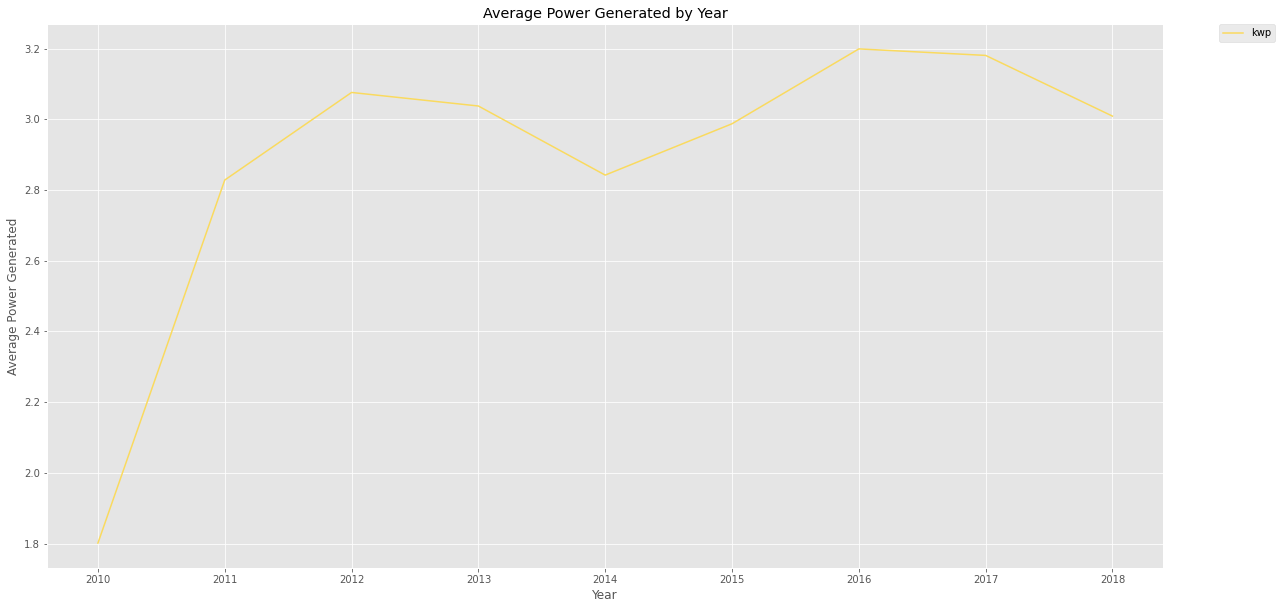

In [34]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('ggplot')
palette={'#fada5e'}
sns.lineplot(data=plot1, palette=palette)

# titles
plt.xlabel('Year') 
plt.ylabel('Average Power Generated')   
plt.title("Average Power Generated by Year")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Next, the pv systems will be mapped. The map will allow the user to determine how much energy was produced by each pv system from 2010-2018.

In [35]:
 #Creating a graph that will show power generation in the UK by year and month
import plotly.express as px

fig = px.scatter_geo(missing_pv, lat="latitude_rounded", lon="longitude_rounded", color="kwp",
                     hover_name="ss_id", size="kwp",
                     animation_frame="year",
                     projection="natural earth",
                     scope ='europe',
                     color_continuous_scale=["blue", "purple", "red"],
                     center=dict(lat=missing_pv.latitude_rounded.mean(), lon=missing_pv.longitude_rounded.mean()))

fig.update_traces(marker=dict(size=10))
fig.update_layout(autosize=True,height=600,geo=dict(projection_scale=6))
fig.show()

-------
## III) pv 5min vs. pv metadata

This section will briefly explore pv systems included in the 5min data vs. those that were included in the metadata.

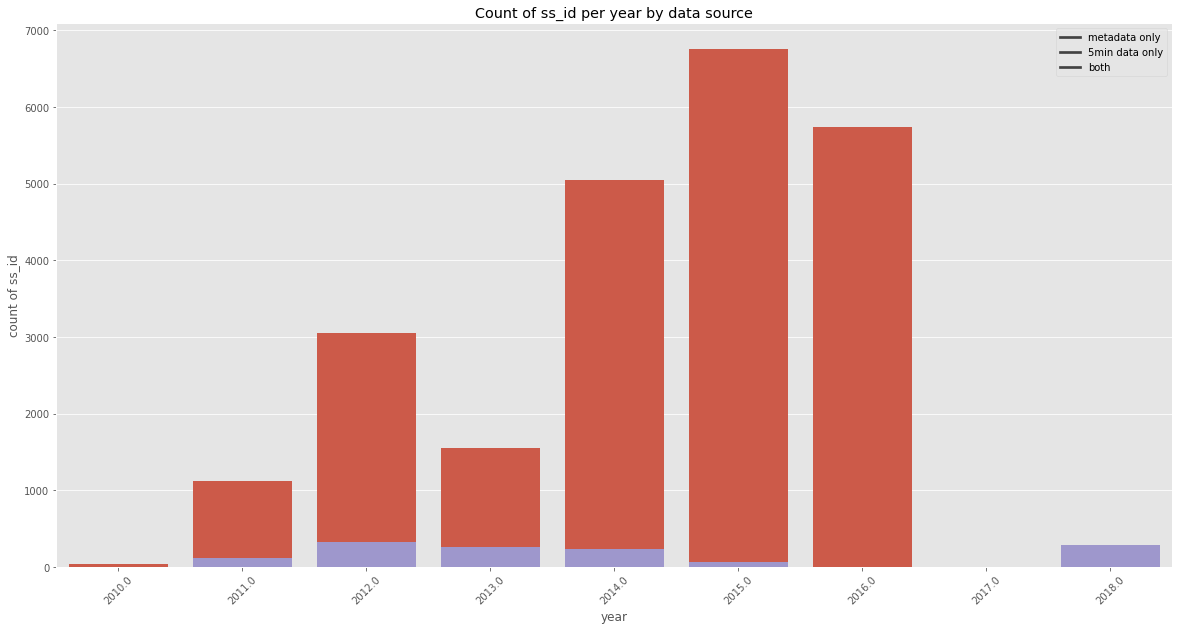

In [44]:
# Prepairing data
# ---- converting 'operational_at' column to datetime
missing['operational_at'] = pd.to_datetime(missing['operational_at'])
# ---- Decomposing date
missing['year'],missing['month'],missing['day'] = missing['operational_at'].dt.year, missing['operational_at'].dt.month, missing['operational_at'].dt.day, 

# Grouping data
plot2 = missing.groupby(['year','_merge']).agg({'ss_id': 'count'}).sort_values('year', ascending=True).reset_index()

#------------Plotting
# defining figure parameters
plt.rcParams["figure.figsize"] = (20,10)
mylabels=['metadata only','5min data only','both']

# plotting
ax = sns.barplot(x='year', y='ss_id', data=plot2, hue='_merge', dodge=False, )

# Lables
plt.title("Count of ss_id per year by data source")
plt.xticks(rotation=45)
plt.ylabel("count of ss_id")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.legend(labels=mylabels)